In [9]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [11]:
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

In [12]:
import gym

In [13]:
env = gym.envs.make("MountainCar-v0")
#env = gym.envs.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
??env.env

In [ ]:
s = env.reset()
# states are (position,velocity), position from -1.2 to 0.6, velocity from -0.07 to 0.07
# actions are: 0 = push left, 1 = do nothing, 2 = push right
s

In [14]:
class Memory():
    def __init__(self, mem_size = 1000000):
        self.mem_size = mem_size
        self.mem = []
        
    def add(self, transition):
        if len(self.mem) == self.mem_size:
            del self.mem[0]
        self.mem.append(transition)
        
    def sample(self, batch_size):
        if batch_size > len(self.mem):
            self.mem = self.mem * batch_size
        
        samples = random.sample(self.mem, batch_size)
        return samples

In [15]:
# Single hidden layer with 256 hidden nodes DQN
class DQN(nn.Module):
    def __init__(self, num_in, num_out):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_in, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, num_out)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [16]:
def compute_q_val(model, state, action):
    # T tensor, T = [[1,2],[3,4],[5,6]], T[row_indexes,index_for_each_row], T[[0,1,2],[0,0,1]]=[1,3,6]
    return model(torch.tensor(state,dtype=torch.float))[range(0,len(action)),action]
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE
    
    # For given (state,action), the target is: reward + discount_factor * max_a{Q(next_state,a)}
    # If next_state is terminal state, then target is just equal to: reward
    Q = model(next_state)
    max_Q_vals, indices = torch.max(Q, 1)
    mask = torch.tensor(1-done, dtype=torch.float)
    target = reward + mask * discount_factor * max_Q_vals
    return target

In [17]:
def calc_reward(s,g):
    q = 0.025
    if abs(s[0] - g) < q:
        r = 0
    else:
        r = -1
    
    return r

In [18]:
# Create experience replay buffer
mem_size = 40000
mem = Memory(mem_size)

In [19]:
# MC = MOUNTAINCAR

# Create DQNs
num_in_MC = 2 #4     #
num_out_MC = 3 #2    #
eval_dqn = DQN(num_in_MC+1, num_out_MC)
target_dqn = DQN(num_in_MC+1, num_out_MC)
target_dqn.load_state_dict(eval_dqn.state_dict())
print(eval_dqn)

DQN(
  (fc1): Linear(in_features=3, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


In [20]:
# Hyper parameters
epsilon_start = 1.0
epsilon_min = 0.05
epsilon = epsilon_start
gamma = 1.0
rep_buffer_size = 1e6

num_epochs = 1
num_epi_per_epoch = 2000
#num_steps = 

batch_size = 64
#target_dqn_update_freq = 50

NUM_ACTIONS = 3

In [21]:
#
learning_rate = 1e-3
loss_func = torch.nn.MSELoss()
optimizer = optim.Adam(eval_dqn.parameters(), lr=learning_rate)

In [22]:
def do_train_step(eval_dqn,target_dqn,loss_func,optimizer,minibatch):
    state,action,reward,next_state,done = zip(*minibatch)
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)
    reward = torch.tensor(reward, dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)

    #compute the q value
    q_val = compute_q_val(eval_dqn, state, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(target_dqn, reward, next_state, done, gamma)

    loss = loss_func(q_val,target)
            
    #
    optimizer.zero_grad()
    loss.backward()
#            for param in dqn.parameters():
#                param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return

In [23]:
num_updates = 0

qq = []

# starting goal
g0 = 0.5
G = [g0]

epsilon = epsilon_start

update_count = 0

#
for epoch in range(0, num_epochs):
    #
#    for epi in range(0, num_epi_per_epoch):
    for epi in tqdm(range(0, num_epi_per_epoch)):
        #print("Starting episode: " + str(epi))
        s = env.reset()
        real_epi_exp = []
        
        epsilon = epsilon*0.95
        epsilon = max(epsilon_min, epsilon)
        #print(epsilon)

        g = random.sample(G,1)[0]
        #print("Current goal: "+str(g))
        
        # EXPERIENCE
        q = 0
        while True: # or set max_num_steps?
            s_g = np.concatenate([s,[g]])
            # epsilon-greedy policy
            if random.uniform(0,1) < epsilon:
                action = np.random.randint(NUM_ACTIONS)
            else:
                input_s_g = torch.tensor(s_g,dtype=torch.float)
                action_vals = eval_dqn(input_s_g)
                val,ind = torch.max(action_vals, 0)
                action = ind.item()
                
            next_state,_,done,_ = env.step(action)
#            if done == True:
#                print("REAL DONE was here!!!!")
                
            next_state_g = np.concatenate([next_state,[g]])
            reward = calc_reward(next_state,g)
            
            if reward != -1:
                done = True
            
            experience = (s,action,next_state)
            real_epi_exp.append(experience)
            
            transition = (s_g,action,reward,next_state_g,done)
            mem.add(transition)
            
            q=q+reward
            
            # Train network
            # Sample minimatch

            if len(mem.mem) > batch_size:
                minibatch = mem.sample(batch_size)
                do_train_step(eval_dqn,target_dqn,loss_func,optimizer,minibatch)
                num_updates = num_updates + 1

            
            if done == True:
                # Update target network
                target_dqn.load_state_dict(eval_dqn.state_dict())
                break
            else:
                s = next_state
#        print(q)
        qq.append(q)
        
        
        # Add to experience replay
        _,_,all_ns = zip(*real_epi_exp)
#        if random.randint(0,1) == 0:
#            # take max position as new goal
#            goal_index = np.argmax(np.array(all_ns)[:,0])
#            #print("00000")
#        else:
#            # take min position as new goal
#            goal_index = np.argmin(np.array(all_ns)[:,0])
#            #print("11111")
        goal_index = np.argmax(np.abs(0.5 + np.array(all_ns)[:,0]))
    
        _,_,g_new = real_epi_exp[goal_index]
        g_new = g_new[0]
        g_new = 0.1*round(10*g_new)
        g_new = 0.01*round(100*g_new)
        #print("gnew " + str(g_new))

        for t in range(0, goal_index): # =(goal_index+1)-1
            s,a,next_s = real_epi_exp[t]
            s_g_new = np.concatenate([s,[g_new]])
            next_s_g_new = np.concatenate([next_s,[g_new]])
            r_new = calc_reward(next_s,g_new)
            if r_new != -1:
                done = True
            else:
                done = False
            transition = (s_g_new,a,r_new,next_s_g_new,done)
            mem.add(transition)

        if g_new not in G:
            G.append(g_new)
        #print(len(mem.mem))

# Save model
model_filename = "dqn_model.pth"
torch.save(eval_dqn.state_dict(), model_filename) #torch.save(dqn, model_filename)

100%|██████████| 1000/1000 [02:36<00:00,  8.18it/s]


In [24]:
print("num_updates: " + str(num_updates))
print(G)

num_updates: 109531
[0.5, -0.7000000000000001, -0.6, -0.4, -0.8, -0.1, 0.2, -0.9, -0.2, 0.0, -0.3, 0.1, -1.2, -1.0, 0.4, -0.5, -1.1, 0.3]


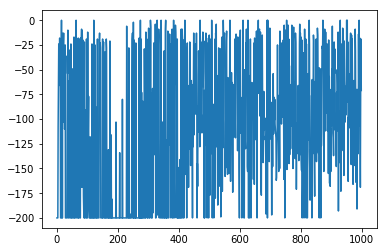

In [26]:
plt.plot(qq)

In [27]:
# Testing
saved_model = torch.load("dqn_model.pth")
#saved_dqn = DQN(2, 3)
saved_dqn = DQN(3, 3)
saved_dqn.load_state_dict(saved_model)
print(saved_dqn)

DQN(
  (fc1): Linear(in_features=3, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


In [28]:
num_episodes_test = 100

total_rewards = []
#successes = []

for epi in range(0,num_episodes_test):
    s = env.reset()
    
    success = 0
    total_reward = 0
    g = 0.5
    while True:
        s_g = np.concatenate([s,[g]])
        input_s_g = torch.tensor(s_g,dtype=torch.float)
        action_vals = saved_dqn(input_s_g)
        val,ind = torch.max(action_vals, 0)
        action = ind.item()
        
        next_state,reward,done,_ = env.step(action)
        total_reward = total_reward + reward
        if done == True:
            break
        else:
            s = next_state
    
    total_rewards.append(total_reward)
#    successes.append(success)

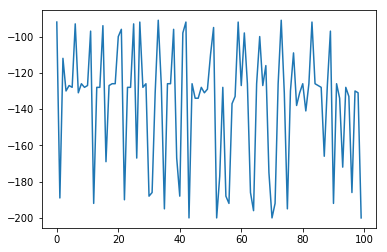

In [29]:
plt.plot(total_rewards)
plt.show()

In [30]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
s = env.reset()
env.render()
done = False
k=0

g = 0.5
while not done:
    s_g = np.concatenate([s,[g]])
    input_s_g = torch.tensor(s_g,dtype=torch.float)
    action_vals = saved_dqn(input_s_g)
    val,ind = torch.max(action_vals, 0)
    action = ind.item()
    
    obs, reward, done, _ = env.step(action)
    env.render()
    time.sleep(0.05)
#    print(k)
    k=k+1
    if done:
        print(k)
    else:
        s = obs
#    print(done)
env.close()  # Close the environment or you will have a lot of render screens soon

126


In [ ]:
import random
random.uniform(0,1)

In [ ]:
Q = torch.rand(4,2)
Q